# Problem Statement

Santander wants to find which customers will make a specific transaction in the future, irrespective of the amount of money transacted.

#### This kernels consists of : 

* Importing Data
* Reducing Memory Usage
* Missing Values
* Basic EDA
* Feature Correlation
* Preprocessing of the data and saving the preprocessed dataset for usage in different algorithms

In [1]:
#!pip install bayesian-optimization


In [2]:
import gc
import os
import time
import math
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold

from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold

# Importing all models

# Classification
from sklearn.linear_model import LogisticRegression, ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, \
    RandomForestClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, \
    RandomForestRegressor, VotingRegressor


#import lightgbm as lgb
#import xgboost as xgb
#import catboost as cat
#from catboost import Pool, CatBoostClassifier

import warnings
#print(os.listdir("../input"))
warnings.simplefilter('ignore')

In [3]:
total_start_time = time.time()

# Importing Data and Reducing Memory

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [5]:
train = import_data("train_ver2.csv")
test = import_data("test_ver2.csv")
sub = import_data("sample_submission.csv")

print("\n\nTrain Size : \t{}\nTest Size : \t{}".format(train.shape, test.shape))


Memory usage of dataframe is 4997.79 MB
Memory usage after optimization is: 859.42 MB
Decreased by 82.8%
Memory usage of dataframe is 170.22 MB
Memory usage after optimization is: 58.01 MB
Decreased by 65.9%
Memory usage of dataframe is 14.18 MB
Memory usage after optimization is: 4.43 MB
Decreased by 68.7%


Train Size : 	(13647309, 48)
Test Size : 	(929615, 24)


In [6]:
train.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [7]:
train.columns #PrinceG : 
#Train data has 24 columns to be used as features. Last 24 columsn represent the product to be recommended

Index(['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel',
       'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
       'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'cod_prov',
       'nomprov', 'ind_actividad_cliente', 'renta', 'segmento',
       'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1'],
      dtype='object')

In [8]:
test.columns #PrinceG : Test data has only the columns to be used as features

Index(['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel',
       'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
       'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'cod_prov',
       'nomprov', 'ind_actividad_cliente', 'renta', 'segmento'],
      dtype='object')

In [9]:
train_features= pd.DataFrame(train,columns=['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel',
       'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
       'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'cod_prov',
       'nomprov', 'ind_actividad_cliente', 'renta', 'segmento'])
train_features.columns

Index(['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo',
       'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel',
       'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
       'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'cod_prov',
       'nomprov', 'ind_actividad_cliente', 'renta', 'segmento'],
      dtype='object')

In [10]:
def missing_values(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                              "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

#miss_train = missing_values(train)
#miss_test = missing_values(test)

In [11]:
traintesting = pd.DataFrame(train.values,columns=['date', 'customer_code', 'emp_status', 'residence_code', 'sex', 'age', 'date_first_prod', 'new_customer', 'seniority_inmonths',
'prime_customer', 'prime_lastdate', 'customer_type', 'customer_relation', 'is_residence', 'is_foreigner', 'spouse', 'channel',
'deceased', 'primary_address', 'province_code', 'province_name', 'status_ai', 'gincome', 'social_segment', 'Saving_Account',
 'Guarantees', 'Current_Accounts', 'Derivada_Account', 'Payroll_Account', 'Junior_Account', 'Más_particular_Account', 
 'particular_Account', 'particular_Plus_Account', 'Short_term_deposits', 'Medium_term_deposits', 'Long_term_deposits', 
 'e_account', 'Funds', 'Mortgage', 'Pensions', 'Loans', 'Taxes', 'Credit_Card', 'Securities', 'Home_Account', 'Payroll',
 'Pensions2', 'Direct_Debit'])
traintesting['Saving_Account'].replace(1,'Saving Account',inplace=True)
traintesting['Guarantees'].replace(1,'Guarantees',inplace=True)
traintesting['Current_Accounts'].replace(1,'Current Accounts',inplace=True)
traintesting['Derivada_Account'].replace(1,'Derivada Account',inplace=True)
traintesting['Payroll_Account'].replace(1,'Payroll Account',inplace=True)
traintesting['Junior_Account'].replace(1,'Junior Account',inplace=True)
traintesting['Más_particular_Account'].replace(1,'Más particular Account',inplace=True)
traintesting['particular_Account'].replace(1,'particular Account',inplace=True)
traintesting['particular_Plus_Account'].replace(1,'particular Plus Account',inplace=True)
traintesting['Short_term_deposits'].replace(1,'Short-term deposits',inplace=True)
traintesting['Medium_term_deposits'].replace(1,'Medium-term deposits',inplace=True)
traintesting['Long_term_deposits'].replace(1,'Long-term deposits',inplace=True)
traintesting['e_account'].replace(1,'e-account',inplace=True)
traintesting['Funds'].replace(1,'Funds',inplace=True)
traintesting['Mortgage'].replace(1,'Mortgage',inplace=True)
traintesting['Pensions'].replace(1,'Pensions',inplace=True)
traintesting['Loans'].replace(1,'Loans',inplace=True)
traintesting['Taxes'].replace(1,'Taxes',inplace=True)
traintesting['Credit_Card'].replace(1,'Credit Card',inplace=True)
traintesting['Securities'].replace(1,'Securities',inplace=True)
traintesting['Home_Account'].replace(1,'Home Account',inplace=True)
traintesting['Payroll'].replace(1,'Payroll',inplace=True)
traintesting['Pensions2'].replace(1,'Pensions2',inplace=True)  
traintesting['Direct_Debit'].replace(1,'Direct Debit',inplace=True)

In [12]:
start_time = time.time()

traintesting['Saving_Account'].replace(0,'',inplace=True)
traintesting['Guarantees'].replace(0,'',inplace=True)
traintesting['Current_Accounts'].replace(0,'',inplace=True)
traintesting['Derivada_Account'].replace(0,'',inplace=True)
traintesting['Payroll_Account'].replace(0,'',inplace=True)
traintesting['Junior_Account'].replace(0,'',inplace=True)
traintesting['Más_particular_Account'].replace(0,'',inplace=True)
traintesting['particular_Account'].replace(0,'',inplace=True)
traintesting['particular_Plus_Account'].replace(0,'',inplace=True)
traintesting['Short_term_deposits'].replace(0,'',inplace=True)
traintesting['Medium_term_deposits'].replace(0,'',inplace=True)
traintesting['Long_term_deposits'].replace(0,'',inplace=True)
traintesting['e_account'].replace(0,'',inplace=True)
traintesting['Funds'].replace(0,'',inplace=True)
traintesting['Mortgage'].replace(0,'',inplace=True)
traintesting['Pensions'].replace(0,'',inplace=True)
traintesting['Loans'].replace(0,'',inplace=True)
traintesting['Taxes'].replace(0,'',inplace=True)
traintesting['Credit_Card'].replace(0,'',inplace=True)
traintesting['Securities'].replace(0,'',inplace=True)
traintesting['Home_Account'].replace(0,'',inplace=True)
traintesting['Payroll'].replace(0,'',inplace=True)
traintesting['Pensions2'].replace(0,'',inplace=True)  
traintesting['Direct_Debit'].replace(0,'',inplace=True)

print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

#traintesting.to_excel(r'C:\Users\d291354\Documents\ML Course\traintesting1.xlsx',index = False)
traintesting

Done. Time elapsed: 9.01s


,date,customer_code,emp_status,residence_code,sex,age,date_first_prod,new_customer,seniority_inmonths,prime_customer,...,Mortgage,Pensions,Loans,Taxes,Credit_Card,Securities,Home_Account,Payroll,Pensions2,Direct_Debit
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0,6,1,...,,,,,,,,,,
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0,35,1,...,,,,,,,,,,
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0,35,1,...,,,,,,,,,,
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0,35,1,...,,,,,,,,,,
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0,35,1,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13647304,2016-05-28,1166765,N,ES,V,22,2013-08-14,0,33,1,...,,,,,,,,,,
13647305,2016-05-28,1166764,N,ES,V,23,2013-08-14,0,33,1,...,,,,,,,,,,
13647306,2016-05-28,1166763,N,ES,H,47,2013-08-14,0,33,1,...,,,,,,,,,,
13647307,2016-05-28,1166789,N,ES,H,22,2013-08-14,0,33,1,...,,,,,,,,,,


In [13]:
start_time= time.time()
traintesting = traintesting.assign(ProductRecommed = traintesting.Saving_Account.astype(str) + ', ' +
traintesting.Guarantees.astype(str)+ ', ' + \
traintesting.Current_Accounts.astype(str)
+ ', ' + \
traintesting.Derivada_Account.astype(str)
+ ', ' + \
traintesting.Payroll_Account.astype(str)
+ ', ' + \
traintesting.Junior_Account.astype(str)
+ ', ' + \
traintesting.Más_particular_Account.astype(str)
+ ', ' + \
traintesting.particular_Account.astype(str)
+ ', ' + \
traintesting.particular_Plus_Account.astype(str)
+ ', ' + \
traintesting.Short_term_deposits.astype(str)
+ ', ' + \
traintesting.Medium_term_deposits.astype(str)
+ ', ' + \
traintesting.Long_term_deposits.astype(str)
+ ', ' + \
traintesting.e_account.astype(str)
+ ', ' + \
traintesting.Funds.astype(str)
+ ', ' + \
traintesting.Mortgage.astype(str)
+ ', ' + \
traintesting.Pensions.astype(str)
+ ', ' + \
traintesting.Loans.astype(str)
+ ', ' + \
traintesting.Taxes.astype(str)
+ ', ' + \
traintesting.Credit_Card.astype(str)
+ ', ' + \
traintesting.Securities.astype(str)
+ ', ' + \
traintesting.Home_Account.astype(str)
+ ', ' + \
traintesting.Payroll.astype(str)
+ ', ' + \
#traintesting.Pensions2.astype(str)
#+ ', ' + \
traintesting.Direct_Debit.astype(str))
print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))
traintesting['ProductRecommed']

Done. Time elapsed: 118.66s


0           , , Current Accounts, , , , , , , , , , , , , ...
1           , , Current Accounts, , , , , , , , , , , , , ...
2           , , Current Accounts, , , , , , , , , , , , , ...
3           , , , , , , , , , Short-term deposits, , , , ,...
4           , , Current Accounts, , , , , , , , , , , , , ...
                                  ...                        
13647304    , , Current Accounts, , , , , , , , , , , , , ...
13647305    , , Current Accounts, , , , , , , , , , , , , ...
13647306    , , Current Accounts, , , , , , , , , , , , , ...
13647307    , , Current Accounts, , , , , , , , , , , , , ...
13647308    , , Current Accounts, , , , Más particular Acc...
Name: ProductRecommed, Length: 13647309, dtype: object

In [14]:
start_time = time.time()
traintesting['ProductRecommed'] = traintesting['ProductRecommed'].replace(' ,','',regex=True).str.strip(' ,')
#traintesting2['ProductRecommed'] = traintesting2['ProductRecommed'].replace(',,','', regex=True)
#traintesting2['ProductRecommed'] = traintesting2['ProductRecommed'].replace(' ','', regex=True)
#traintesting.to_excel(r'C:\Users\d291354\Documents\ML Course\traintesting.xlsx',index = False)
traintesting
print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

Done. Time elapsed: 33.04s


In [15]:
start_time = time.time()
reduce_mem_usage(traintesting)
print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

Memory usage of dataframe is 5101.91 MB
Memory usage after optimization is: 866.02 MB
Decreased by 83.0%
Done. Time elapsed: 243.94s


In [16]:
## Drop Columns contributing for Product Recommendations (24 Columns in end)
traintesting.drop(columns=['Saving_Account',
 'Guarantees', 'Current_Accounts', 'Derivada_Account', 'Payroll_Account', 'Junior_Account', 'Más_particular_Account', 
 'particular_Account', 'particular_Plus_Account', 'Short_term_deposits', 'Medium_term_deposits', 'Long_term_deposits', 
 'e_account', 'Funds', 'Mortgage', 'Pensions', 'Loans', 'Taxes', 'Credit_Card', 'Securities', 'Home_Account', 'Payroll',
 'Pensions2','Direct_Debit'],axis=1,inplace=True)

In [17]:
traintesting.drop(columns=['province_name'],axis=1,inplace=True) #Province Code shall be used instead

In [18]:
traintesting['ProductRecommed'].value_counts()

Current Accounts                                                                                                                                                                     6075368
                                                                                                                                                                                     2552020
Current Accounts, particular Account                                                                                                                                                  685287
Current Accounts, Direct Debit                                                                                                                                                        411367
particular Account                                                                                                                                                                    406060
                                                       

In [19]:
## verify which all columns have Null / NaN values
traintesting.isnull().sum()

date                         0
customer_code                0
emp_status               27734
residence_code           27734
sex                      27804
age                          0
date_first_prod          27734
new_customer             27734
seniority_inmonths           0
prime_customer           27734
prime_lastdate        13622516
customer_type           149781
customer_relation       149781
is_residence             27734
is_foreigner             27734
spouse                13645501
channel                 186126
deceased                 27734
primary_address          27735
province_code            93591
status_ai                27734
gincome                2794375
social_segment          189368
ProductRecommed              0
dtype: int64

In [20]:
traintesting['date'] = traintesting['date'].replace('-','',regex=True).str.strip(' ,')

In [21]:
traintesting['date_first_prod'] = traintesting['date_first_prod'].replace('-','',regex=True).str.strip(' ,')
traintesting['prime_lastdate'] = traintesting['prime_lastdate'].replace('-','',regex=True).str.strip(' ,')



In [22]:
#traintesting['date_first_prod'] = traintesting['date_first_prod'].fillna('0',inplace=True)
#traintesting['prime_lastdate'] = traintesting['prime_lastdate'].fillna('0',inplace=True)

In [23]:
traintesting['date_first_prod']

0           20150112
1           20120810
2           20120810
3           20120810
4           20120810
              ...   
13647304    20130814
13647305    20130814
13647306    20130814
13647307    20130814
13647308    20160513
Name: date_first_prod, Length: 13647309, dtype: object

In [24]:
##Create a new dictionary for ProductRecommendation Column and map it: Prince G
daf = pd.DataFrame(traintesting['ProductRecommed'].unique())
di= daf.to_dict()
new_dict_pr_recommed = dict([(value, key) for key, value in di[0].items()]) 
traintesting['ProductRecommed'] = traintesting['ProductRecommed'].map(new_dict_pr_recommed)
traintesting['ProductRecommed']

0            0
1            0
2            0
3            1
4            0
            ..
13647304     0
13647305     0
13647306     0
13647307     0
13647308    20
Name: ProductRecommed, Length: 13647309, dtype: category
Categories (10908, int64): [4, 26, 151, 7383, ..., 6857, 3187, 10067, 8209]

In [25]:
##Create a new dictionary for ProductRecommendation Column and map it: Prince G
daf1 = pd.DataFrame(traintesting['residence_code'].unique())
di1= daf1.to_dict()
#di1[0].items()
new_dict_res_code = dict([(value, key) for key, value in di1[0].items()]) 
#new_dict_res_code
traintesting['residence_code'] = traintesting['residence_code'].map(new_dict_res_code)
traintesting['residence_code']
#new_dict_res_code
#traintesting['residence_code'].unique()

0           0
1           0
2           0
3           0
4           0
           ..
13647304    0
13647305    0
13647306    0
13647307    0
13647308    0
Name: residence_code, Length: 13647309, dtype: category
Categories (118, int64): [35, 37, 25, 71, ..., 14, 90, 75, 114]

In [26]:
##Create a new dictionary for ProductRecommendation Column and map it: Prince G
daf2 = pd.DataFrame(traintesting['channel'].unique())
di2= daf2.to_dict()
#di1[0].items()
new_dict_res_code = dict([(value, key) for key, value in di2[0].items()]) 
#new_dict_res_code
traintesting['channel'] = traintesting['channel'].map(new_dict_res_code)
traintesting['channel']
#new_dict_res_code
#traintesting['residence_code'].unique()

0             0
1             1
2             1
3             2
4             1
           ... 
13647304      1
13647305      1
13647306      1
13647307      1
13647308    NaN
Name: channel, Length: 13647309, dtype: category
Categories (162, int64): [83, 71, 49, 159, ..., 157, 161, 162, 8]

In [27]:
new_dict_res_code

{'KHL': 0,
 'KHE': 1,
 'KHD': 2,
 'KFA': 3,
 'KFC': 4,
 'KAT': 5,
 nan: 6,
 'KAZ': 7,
 'RED': 8,
 'KHC': 9,
 'KHK': 10,
 'KGN': 11,
 'KHM': 12,
 'KHO': 13,
 'KDH': 14,
 'KEH': 15,
 'KAD': 16,
 'KBG': 17,
 'KGC': 18,
 'KHF': 19,
 'KFK': 20,
 'KHN': 21,
 'KHA': 22,
 'KAF': 23,
 'KGX': 24,
 'KFD': 25,
 'KAG': 26,
 'KFG': 27,
 'KAB': 28,
 'KCC': 29,
 'KAE': 30,
 'KAH': 31,
 'KAR': 32,
 'KFJ': 33,
 'KFL': 34,
 'KAI': 35,
 'KFU': 36,
 'KAQ': 37,
 'KFS': 38,
 'KAA': 39,
 'KFP': 40,
 'KAJ': 41,
 'KFN': 42,
 'KGV': 43,
 'KGY': 44,
 'KFF': 45,
 'KAP': 46,
 'KDE': 47,
 'KFV': 48,
 '013': 49,
 'K00': 50,
 'KAK': 51,
 'KCK': 52,
 'KCL': 53,
 'KAY': 54,
 'KBU': 55,
 'KDR': 56,
 'KAC': 57,
 'KDT': 58,
 'KCG': 59,
 'KDO': 60,
 'KDY': 61,
 'KBQ': 62,
 'KDA': 63,
 'KBO': 64,
 'KCI': 65,
 'KEC': 66,
 'KBZ': 67,
 'KES': 68,
 'KDX': 69,
 'KAS': 70,
 '007': 71,
 'KEU': 72,
 'KCA': 73,
 'KAL': 74,
 'KDC': 75,
 'KAW': 76,
 'KCS': 77,
 'KCB': 78,
 'KDU': 79,
 'KDQ': 80,
 'KCN': 81,
 'KCM': 82,
 '004': 83,
 'KC

### Not only they are normally distributed almost all the features have almost same distribution with same scales. 
### Lets check correlation to confirm the same.

# Correlation

In [28]:
def plot_corr(data):
    data_correlation = data.corr()
    f, ax = plt.subplots(figsize=(100, 100))
    sns.heatmap(data_correlation,
                xticklabels=data_correlation.columns.values,
                yticklabels=data_correlation.columns.values, annot=True)
    plt.show()

In [29]:
##Mapping the columns to be used for algorithm to process
traintesting['customer_type'] = traintesting['customer_type'].map({'1.0':1, '1':1, '2.0':2, '2':2, '3.0':3, '3':3, '4.0':4, '4':4, 'P':'5'})
traintesting['emp_status'] = traintesting['emp_status'].map({'N':1, 'A':2, 'B':3, 'F':4, 'S':5})
traintesting['sex'] = traintesting['sex'].map({'V':'1', 'H':'2'})
traintesting['deceased'] = traintesting['deceased'].map({'N':'0', 'S':'1'})
traintesting['is_foreigner'] = traintesting['is_foreigner'].map({'N':'1', 'S':'2'})
traintesting['is_residence'] = traintesting['is_residence'].map({'N':'1', 'S':'2'})
traintesting['spouse'] = traintesting['spouse'].map({'N':'1', 'S':'2'})
traintesting['social_segment'] = traintesting['social_segment'].map({'01 - TOP':'1', '02 - PARTICULARE':'2', '03 - UNIVERSITARIO':'3'})
traintesting['customer_relation'] = traintesting['social_segment'].map({'A':'1', 'I':'2', 'P':'3', 'R':'4', 'N':'5'})
#traintesting.replace(' NA',"0",inplace=True)

In [30]:
traintesting.replace(' NA',"NaN",inplace=True)
traintesting.replace('     NA',"NaN",inplace=True)
#traintesting.replace('',"0",inplace=True)

In [31]:
#traintesting.dropna(axis=1)
traintesting['spouse'].replace('NaN','2',inplace=True)
traintesting['spouse'].unique()
traintesting['spouse'].fillna('2',inplace=True)


In [32]:
traintesting['social_segment'].fillna('3',inplace=True)
traintesting['gincome'].fillna(traintesting['gincome'].mean(),inplace=True)#Gross Income is considered for Mean of incomes. This may be wrong assumption
#traintesting['age'].fillna(traintesting['age'].mean(),inplace=True)#Gross Income is considered for Mean of Age
traintesting['emp_status'].fillna('1',inplace=True)
traintesting['residence_code'].fillna('1',inplace=True)
traintesting['deceased'].fillna('0',inplace=True)
traintesting['new_customer'].fillna('0.0',inplace=True)
traintesting['status_ai'].fillna('0.0',inplace=True)
traintesting['channel'].fillna('1',inplace=True)
traintesting['prime_customer'].fillna('1.0',inplace=True)
traintesting['customer_type'].fillna('1',inplace=True)
traintesting['sex'].fillna('1',inplace=True)
traintesting['is_residence'].fillna('1',inplace=True) #Replace NaN with value 1 means he is not a resident
traintesting['is_foreigner'].fillna('1',inplace=True) #Replace NaN with value 1 means he is not a foreigner
traintesting['customer_relation'].fillna('0',inplace=True)
traintesting['primary_address'].fillna('0',inplace=True)#Replace NaN with 0 as customer has not given Primary address
traintesting['province_code'].fillna('0.0',inplace=True)#Replace NaN with 0.0 , the value not existing in Province Code list
#traintesting['province_name'].fillna('NotPROVIDED',inplace=True)#Replace NaN with NotPROVIDED , the value not existing in Province Name list
traintesting['date_first_prod'].fillna('0',inplace=True)#Replace NaN with 0 , to identfy that date not existing, in such cases the product offering may differ
traintesting['prime_lastdate'].fillna('0',inplace=True)#Replace NaN with 0 , to identfy that date not existing, in such cases the product offering may differ



In [33]:
traintesting['age'].value_counts()

23     542682
24     527526
22     524620
21     500941
20     370847
        ...  
116        12
163         8
127         8
164         3
126         3
Name: age, Length: 235, dtype: int64

In [34]:
traintesting['age'].fillna('25',inplace=True)#May be a wromg assumption from Business prespective
traintesting['age'].replace('NaN','25',inplace=True)#May be a wromg assumption from Business prespective

In [35]:
traintesting['seniority_inmonths'].fillna('100',inplace=True)#May be a wromg assumption from Business prespective
traintesting['seniority_inmonths'].replace('NaN','100',inplace=True)#May be a wromg assumption from Business prespective
traintesting['seniority_inmonths'].unique()

array(['      6', '     35', '     34', '100', '     33', '     31',
       '     21', '     16', '     27', '      9', '     22', '     13',
       '     29', '      8', '     11', '     10', '     28', '     24',
       '      7', '     25', '     14', '     26', '     12', '     23',
       '      1', '     18', '      4', '      3', '     17', '     32',
       '     30', '     20', '     15', '     19', '    157', '     36',
       '      5', '     40', '     38', '     37', '     39', '      0',
       '      2', '     47', '     44', '     42', '     46', '     45',
       '     43', '     41', '     57', '     48', '     52', '     49',
       '     50', '     56', '     58', '     51', '     55', '     54',
       '     53', '     59', '     62', '     61', '     60', '     63',
       '    139', '    165', '    118', '    164', '    142', '     94',
       '    159', '    143', '    105', '    151', '    162', '    137',
       '    150', '    128', '    122', '    156', '   

In [36]:
traintesting['sex'].unique()

array(['2', '1'], dtype=object)

In [37]:
traintesting['age'].unique()

array([' 35', ' 23', ' 22', ' 24', ' 65', ' 28', ' 25', ' 26', ' 53',
       ' 27', ' 32', ' 37', ' 31', ' 39', ' 63', ' 33', ' 55', ' 42',
       ' 58', ' 38', ' 50', ' 30', ' 45', ' 44', ' 36', ' 29', ' 60',
       ' 57', ' 67', ' 47', '25', ' 34', ' 48', ' 46', ' 54', ' 84',
       ' 15', ' 12', '  8', '  6', ' 83', ' 40', ' 77', ' 69', ' 52',
       ' 59', ' 43', ' 10', '  9', ' 49', ' 41', ' 51', ' 78', ' 16',
       ' 11', ' 73', ' 62', ' 66', ' 17', ' 68', ' 82', ' 95', ' 96',
       ' 56', ' 61', ' 79', ' 72', ' 14', ' 19', ' 13', ' 86', ' 64',
       ' 20', ' 89', ' 71', '  7', ' 70', ' 74', ' 21', ' 18', ' 75',
       '  4', ' 80', ' 81', '  5', ' 76', ' 92', ' 93', ' 85', ' 91',
       ' 87', ' 90', ' 94', ' 99', ' 98', ' 88', ' 97', '100', '101',
       '106', '103', '  3', '  2', '102', '104', '111', '107', '109',
       '105', '112', '115', '110', '116', '108', '113', 37, 81, 43, 30,
       45, 41, 67, 59, 46, 36, 47, 69, 39, 44, 40, 38, 34, 42, 31, 35, 48,
       60, 54,

In [38]:
traintesting['social_segment'].value_counts()

3    13085167
1      562142
Name: social_segment, dtype: int64

In [39]:
traintesting['gincome'].value_counts()

134254.318212    2794375
451931.218750       5582
463625.156250       1743
181042.203125       1493
128318.523438       1404
                  ...   
195859.593750          1
106957.320312          1
133142.671875          1
156827.515625          1
78719.398438           1
Name: gincome, Length: 520989, dtype: int64

In [40]:
traintesting['gincome'] = traintesting['gincome'].astype(np.float64)
traintesting['gincome'].unique()

array([ 87218.1015625 ,  35548.73828125, 122179.109375  , ...,
        63867.66015625,  34341.1796875 ,  89018.3671875 ])

In [41]:
## verify which all columns have Null / NaN values
traintesting.isnull().sum()

date                  0
customer_code         0
emp_status            0
residence_code        0
sex                   0
age                   0
date_first_prod       0
new_customer          0
seniority_inmonths    0
prime_customer        0
prime_lastdate        0
customer_type         0
customer_relation     0
is_residence          0
is_foreigner          0
spouse                0
channel               0
deceased              0
primary_address       0
province_code         0
status_ai             0
gincome               0
social_segment        0
ProductRecommed       0
dtype: int64

In [42]:
## Find which all rown and column has NaN
col_mask=traintesting.isnull().any(axis=0) 
row_mask=traintesting.isnull().any(axis=1)
traintesting.loc[row_mask,col_mask]

""


In [43]:
traintesting=traintesting.astype(np.float64)

In [44]:
traintesting.corr()


,date,customer_code,emp_status,residence_code,sex,age,date_first_prod,new_customer,seniority_inmonths,prime_customer,...,is_foreigner,spouse,channel,deceased,primary_address,province_code,status_ai,gincome,social_segment,ProductRecommed
date,1.000000,0.069124,-0.001908,-0.005100,0.005526,-0.006603,0.039706,0.043513,-0.000520,0.001654,...,0.006755,0.000460,0.132126,-0.000354,3.631835e-02,0.002696,-0.051664,-4.646373e-04,0.013645,-0.030065
customer_code,0.069124,1.000000,-0.040606,-0.037870,0.136059,-0.607882,0.068415,0.347167,-0.035620,0.028569,...,0.038477,0.021553,0.162838,-0.055302,8.986821e-03,-0.032034,-0.139885,-7.325436e-02,0.153835,-0.327253
emp_status,-0.001908,-0.040606,1.000000,-0.000537,0.004404,0.010793,-0.001904,-0.005825,0.001953,-0.000936,...,-0.005003,-0.314088,-0.004452,-0.001023,1.058053e-03,0.002643,0.016797,4.893529e-03,-0.020813,0.053058
residence_code,-0.005100,-0.037870,-0.000537,1.000000,-0.008950,0.018959,-0.020817,-0.012964,0.001643,-0.001728,...,0.195724,0.000613,0.006227,-0.001157,-1.851810e-02,-0.108956,0.003689,6.934025e-05,-0.002387,0.000726
sex,0.005526,0.136059,0.004404,-0.008950,1.000000,-0.121752,0.050184,0.025344,-0.003986,-0.000511,...,0.010564,0.000848,0.021098,-0.014720,4.114564e-02,0.004838,-0.050331,-6.746828e-03,0.039072,-0.064273
age,-0.006603,-0.607882,0.010793,0.018959,-0.121752,1.000000,0.003230,-0.152206,0.022087,-0.000792,...,-0.016106,-0.010895,-0.082814,0.109348,3.979004e-02,0.049761,0.136673,6.050487e-02,-0.180383,0.197858
date_first_prod,0.039706,0.068415,-0.001904,-0.020817,0.050184,0.003230,1.000000,0.028849,-0.002876,0.003476,...,0.012219,0.001010,0.024538,-0.001215,9.981197e-01,0.089793,0.032991,-4.535599e-03,0.000204,-0.021131
new_customer,0.043513,0.347167,-0.005825,-0.012964,0.025344,-0.152206,0.028849,1.000000,-0.011149,0.063038,...,0.017108,-0.000420,0.475826,-0.012599,1.133752e-02,-0.000851,-0.003771,-8.654104e-03,0.014545,-0.071924
seniority_inmonths,-0.000520,-0.035620,0.001953,0.001643,-0.003986,0.022087,-0.002876,-0.011149,1.000000,-0.001027,...,-0.000907,-0.001044,-0.007020,0.002181,-6.311068e-04,0.001082,0.004997,2.526933e-03,-0.002509,0.008046
prime_customer,0.001654,0.028569,-0.000936,-0.001728,-0.000511,-0.000792,0.003476,0.063038,-0.001027,1.000000,...,0.004621,-0.000413,-0.000835,0.017780,1.925166e-03,0.000066,-0.032921,1.227613e-05,0.001058,-0.011372


In [45]:
traintesting.corrwith(traintesting['ProductRecommed'])

date                 -0.030065
customer_code        -0.327253
emp_status            0.053058
residence_code        0.000726
sex                  -0.064273
age                   0.197858
date_first_prod      -0.021131
new_customer         -0.071924
seniority_inmonths    0.008046
prime_customer       -0.011372
prime_lastdate       -0.011372
customer_type        -0.004955
customer_relation          NaN
is_residence         -0.003787
is_foreigner         -0.023813
spouse               -0.033880
channel              -0.024242
deceased              0.009395
primary_address      -0.000387
province_code         0.020971
status_ai             0.239565
gincome               0.038550
social_segment       -0.271798
ProductRecommed       1.000000
dtype: float64

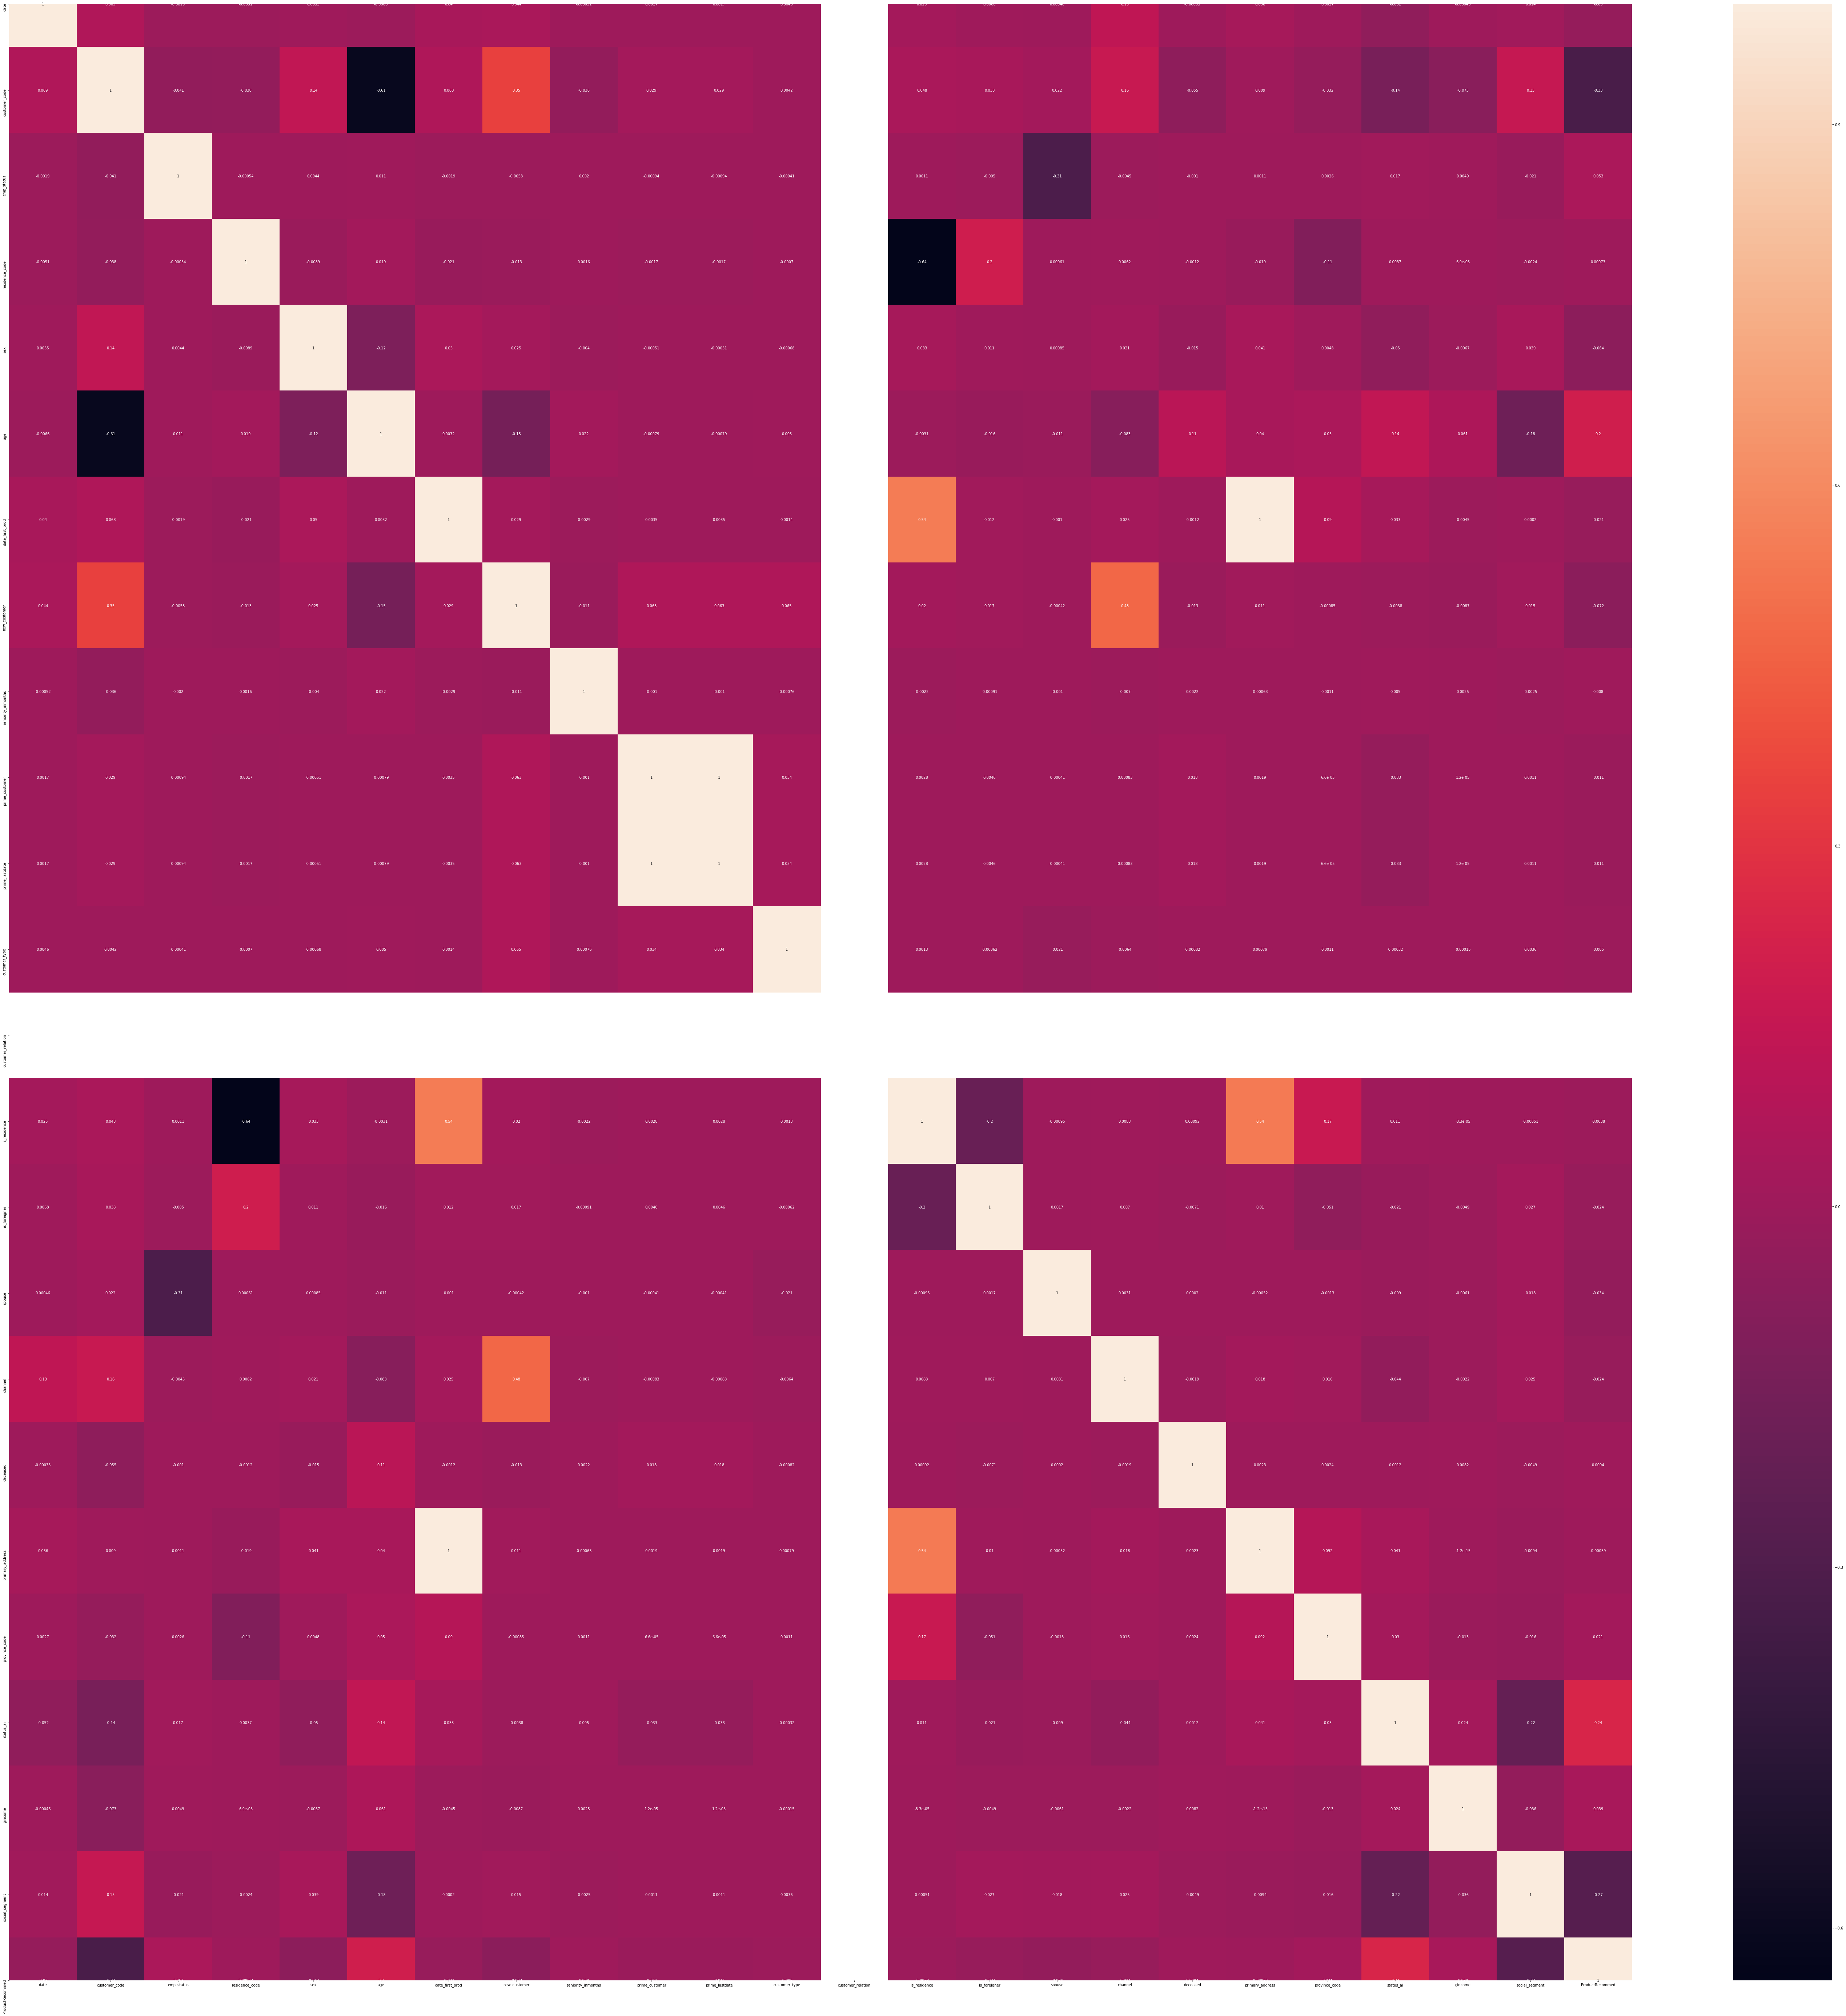

In [46]:
plot_corr(traintesting)

In [47]:
traintesting1 = traintesting.head(1000000)
traintesting1 ### This is to be used for Gradient Boosting Model as complete dataset was taking too much of time

,date,customer_code,emp_status,residence_code,sex,age,date_first_prod,new_customer,seniority_inmonths,prime_customer,...,is_foreigner,spouse,channel,deceased,primary_address,province_code,status_ai,gincome,social_segment,ProductRecommed
0,20150128.0,1375586.0,1.0,0.0,2.0,35.0,20150112.0,0.0,6.0,1.0,...,1.0,2.0,0.0,0.0,1.0,29.0,1.0,87218.101562,3.0,0.0
1,20150128.0,1050611.0,1.0,0.0,1.0,23.0,20120810.0,0.0,35.0,1.0,...,2.0,2.0,1.0,0.0,1.0,13.0,0.0,35548.738281,3.0,0.0
2,20150128.0,1050612.0,1.0,0.0,1.0,23.0,20120810.0,0.0,35.0,1.0,...,1.0,2.0,1.0,0.0,1.0,13.0,0.0,122179.109375,3.0,0.0
3,20150128.0,1050613.0,1.0,0.0,2.0,22.0,20120810.0,0.0,35.0,1.0,...,1.0,2.0,2.0,0.0,1.0,50.0,0.0,119775.539062,3.0,1.0
4,20150128.0,1050614.0,1.0,0.0,1.0,23.0,20120810.0,0.0,35.0,1.0,...,1.0,2.0,1.0,0.0,1.0,50.0,1.0,134254.318212,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,20150228.0,1183296.0,1.0,0.0,2.0,27.0,20130925.0,0.0,22.0,1.0,...,1.0,2.0,4.0,0.0,1.0,28.0,1.0,55516.980469,3.0,12.0
999996,20150228.0,1183295.0,1.0,0.0,2.0,56.0,20130925.0,0.0,22.0,1.0,...,1.0,2.0,4.0,0.0,1.0,15.0,1.0,75654.843750,3.0,0.0
999997,20150228.0,1183294.0,1.0,0.0,1.0,39.0,20130925.0,0.0,22.0,1.0,...,1.0,2.0,4.0,0.0,1.0,15.0,1.0,80634.867188,3.0,28.0
999998,20150228.0,1183293.0,1.0,0.0,1.0,36.0,20130925.0,0.0,22.0,1.0,...,2.0,2.0,4.0,0.0,1.0,28.0,1.0,57818.460938,3.0,2.0


In [64]:
#traintesting.to_csv(r'C:\Users\d291354\Documents\ML Course\traintesting_PreProcessed.csv',index = False)

## Light Gradient Boosting Model

### Documentation related to LGBM:   https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [59]:
import lightgbm as lgb
x_train, x_valid, y_train, y_valid = train_test_split(traintesting.drop(["ProductRecommed"], axis=1), traintesting['ProductRecommed'], test_size=0.2, random_state=13)
def lgb_model(train, feat, target):
    

    train_set = lgb.Dataset(x_train, label=y_train)
    valid_set = lgb.Dataset(x_valid, label=y_valid)

    MAX_ROUNDS = 2000
    params = {
        "boosting": 'gbdt', # "dart",
        "learning_rate": 0.01,
        "nthread": -1,
        "seed": 13,
        "num_boost_round": MAX_ROUNDS,
        #"objective": "binary",
        #"metric": "auc",
        "metric": "None"
    }

    model = lgb.train(
        params,
        train_set=train_set,
        valid_sets=[train_set, valid_set],
        #early_stopping_rounds=50,
        verbose_eval=100
    )

    lgb.plot_importance(model, figsize=(24, 50))

    return model

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.651482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1526
[LightGBM] [Info] Number of data points in the train set: 10917847, number of used features: 22
[LightGBM] [Info] Start training from score 176.574131


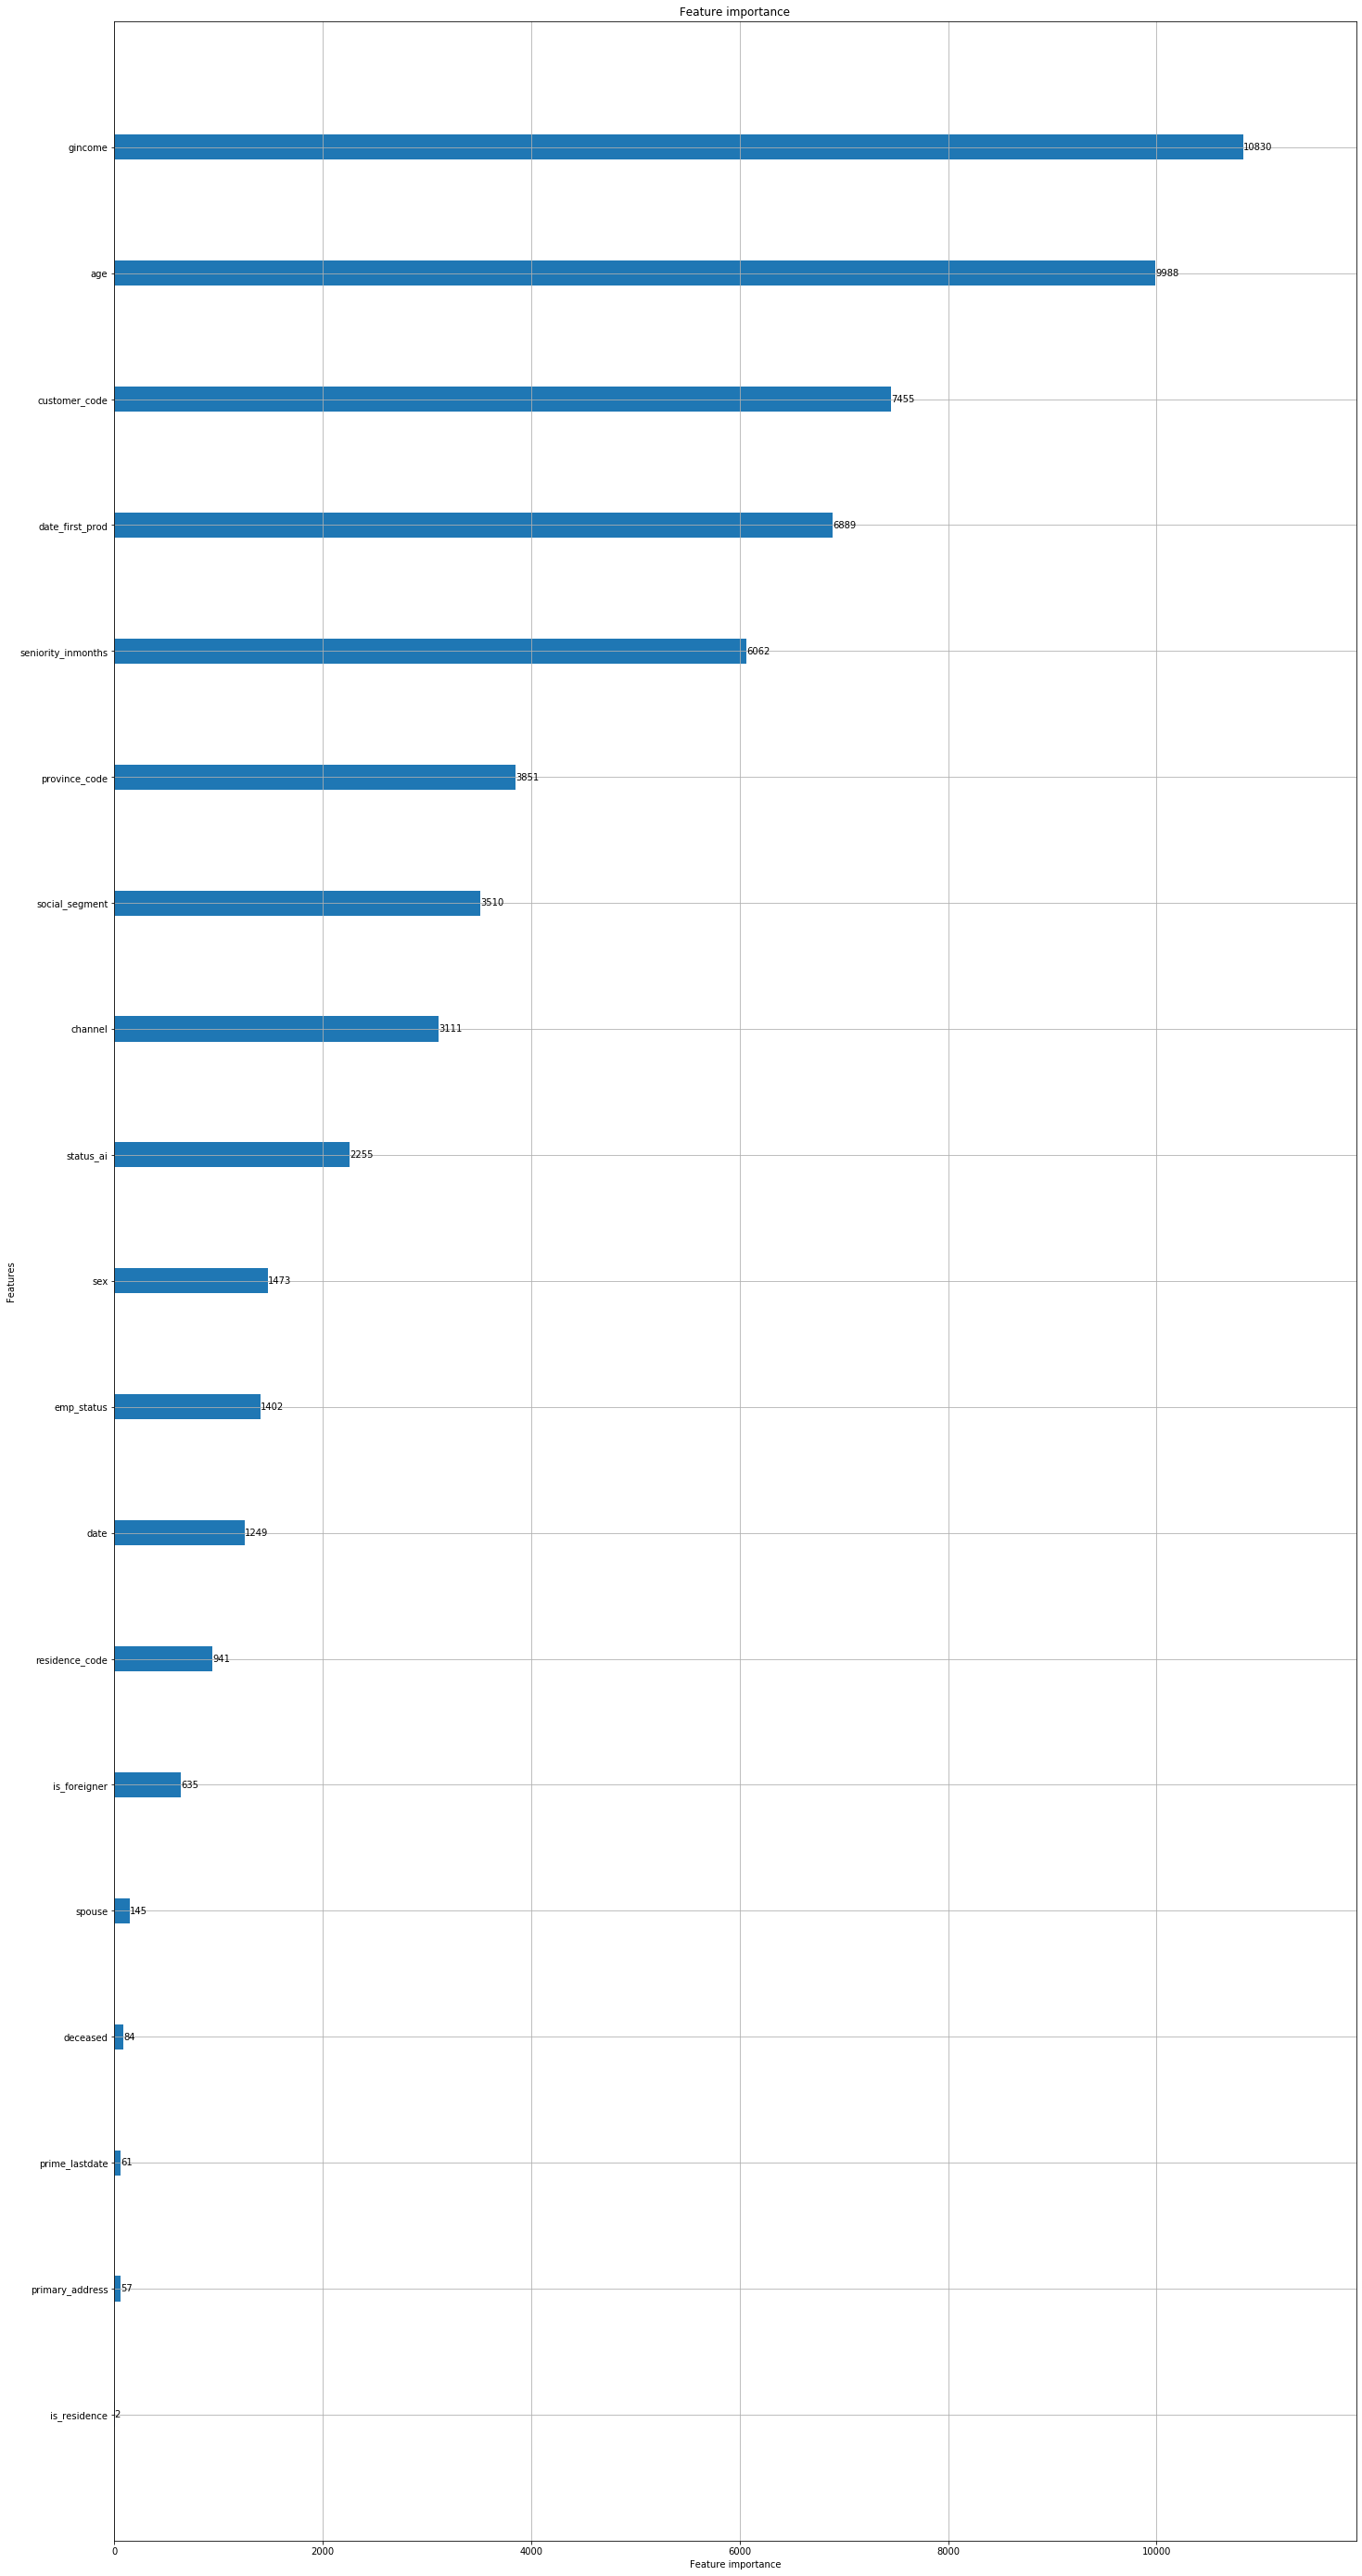

In [60]:
model = lgb_model(traintesting, traintesting.drop(["ProductRecommed"], axis=1), traintesting['ProductRecommed'])

In [61]:
#Prediction
#x_train, x_valid, y_train, y_valid = train_test_split(traintesting.drop(["ProductRecommed"], axis=1), traintesting['ProductRecommed'], test_size=0.2, random_state=13)
y_pred=model.predict(x_valid)
#convert into binary values
#for i in range(0,99):
#    if y_pred[i]>=.5:       # setting threshold to .5
#       y_pred[i]=1
#    else:  
#       y_pred[i]=0
y_pred1= y_pred.astype('int64')

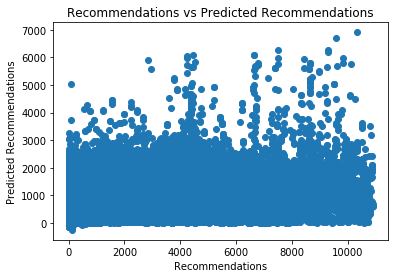

In [62]:
plt.scatter(y_valid, y_pred1)
plt.xlabel("Recommendations")
plt.ylabel("Predicted Recommendations")
plt.title("Recommendations vs Predicted Recommendations")
plt.show()

In [63]:
##
x_valid['ProdRecommed'] = y_valid
x_valid['ProdRecommedPredict'] = y_pred1
x_valid['ProdRecommed'].astype('str')
daf[0].astype('str')
x_valid['ProdRecommed'] = x_valid['ProdRecommed'].map(daf[0])
#x_test['ProdRecommed'] = x_test['ProdRecommed'].remap(daf)
x_valid['ProdRecommedPredict'] = x_valid['ProdRecommedPredict'].map(daf[0])

In [64]:
x_valid

,date,customer_code,emp_status,residence_code,sex,age,date_first_prod,new_customer,seniority_inmonths,prime_customer,...,spouse,channel,deceased,primary_address,province_code,status_ai,gincome,social_segment,ProdRecommed,ProdRecommedPredict
13044013,20160528.0,127040.0,1.0,0.0,2.0,44.0,19990405.0,0.0,206.0,1.0,...,2.0,5.0,0.0,1.0,28.0,1.0,90723.687500,3.0,"Current Accounts, Payroll Account, particular ...","Payroll Account, particular Plus Account, Taxe..."
3183259,20150628.0,1042712.0,1.0,0.0,2.0,41.0,20120803.0,0.0,35.0,1.0,...,2.0,1.0,0.0,1.0,8.0,1.0,91011.539062,3.0,"Current Accounts, Direct Debit","Payroll Account, Payroll"
3708289,20150628.0,506552.0,1.0,0.0,2.0,57.0,20041214.0,0.0,127.0,1.0,...,2.0,23.0,0.0,1.0,41.0,0.0,75419.398438,3.0,particular Account,"Current Accounts, Long-term deposits, e-accoun..."
296346,20150128.0,1200302.0,1.0,0.0,1.0,23.0,20131015.0,0.0,21.0,1.0,...,2.0,1.0,0.0,1.0,28.0,0.0,84902.492188,3.0,Current Accounts,Current Accounts
6532425,20151028.0,1035422.0,1.0,0.0,1.0,24.0,20120730.0,0.0,39.0,1.0,...,2.0,1.0,0.0,1.0,41.0,0.0,108533.070312,3.0,Current Accounts,Current Accounts
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10296386,20160228.0,648743.0,1.0,0.0,1.0,43.0,20061016.0,0.0,100.0,1.0,...,2.0,71.0,0.0,1.0,28.0,0.0,73694.523438,3.0,,Credit Card
1310650,20150328.0,444671.0,1.0,0.0,1.0,55.0,20031113.0,0.0,140.0,1.0,...,2.0,5.0,0.0,1.0,28.0,0.0,137846.843750,3.0,Current Accounts,"Current Accounts, Más particular Account, Cred..."
12474186,20160428.0,1012170.0,1.0,0.0,1.0,11.0,20120413.0,0.0,48.0,1.0,...,2.0,3.0,0.0,1.0,28.0,1.0,142969.859375,3.0,Junior Account,Taxes
1490040,20150328.0,368245.0,1.0,0.0,1.0,69.0,20020703.0,0.0,6.0,1.0,...,2.0,0.0,0.0,1.0,29.0,1.0,124218.093750,3.0,Current Accounts,"Current Accounts, e-account, Credit Card"


In [68]:
import sklearn.metrics as metrics
print('R^2:',metrics.r2_score(y_valid, y_pred))
#print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_valid, y_pred))
print('MSE:',metrics.mean_squared_error(y_valid, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_valid, y_pred)))

R^2: 0.2820697702331728
MAE: 167.91742497713958
MSE: 246732.45598487084
RMSE: 496.72170879162394


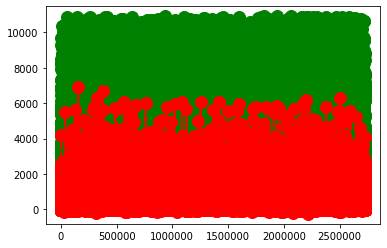

In [69]:
plt.plot(np.arange(len(y_valid)),y_valid ,color='green', marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.plot(np.arange(len(y_pred)),y_pred ,color='red', marker='o', linestyle='dashed',linewidth=2, markersize=12)

In [ ]:
import pickle
filename = 'lgb.sav'
pickle.dump(model, open(filename, 'wb'))
# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(x_test,y_test)
#y_predict= loaded_model.predict(x_test)
#print(y_predict)

# the problem with LGBM is the predictions are not in corrct integer format and thus variations from Actual Prediction may be high, thus not an ideal model to consider

## Gradient Boosting Model

In [63]:
start_time = time.time()
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
#X, y = make_regression(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(traintesting1.drop(['ProductRecommed'], axis=1), traintesting1['ProductRecommed'],test_size = 0.30, random_state= 355)
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
GradientBoostingRegressor(random_state=0)
#reg.predict(X_test[1:2])

#reg.score(X_test, y_test)


print('Done. Time elapsed for Gradient Boost Model Training: {:.2f}s'.format(time.time() - start_time))

Done. Time elapsed for Gradient Boost Model Training: 1743.59s


In [64]:
reg.predict(X_test)

reg.score(X_test, y_test)

0.2560409440005277

## Gradeint Booster has given only 25.6% score thus not relevant for our case

In [65]:
from sklearn.linear_model import LinearRegression

# Create a Linear regressor
lm = LinearRegression()

# Train the model using the training sets 
lm.fit(traintesting.drop(['ProductRecommed'], axis=1), traintesting['ProductRecommed'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [66]:
lm.intercept_

12305.164731799245

In [67]:
coeffcients = pd.DataFrame([traintesting.columns,lm.coef_]).T
coeffcients = coeffcients.rename(columns={0: 'Attribute', 1: 'Coefficients'})
coeffcients

,Attribute,Coefficients
0,date,-0.000502912
1,customer_code,-1.52403e-06
2,emp_status,299.414
3,residence_code,-0.691963
4,sex,-9.18035
5,age,-1.51129
6,date_first_prod,-0.00328964
7,new_customer,17.5763
8,seniority_inmonths,-0.0012811
9,prime_customer,-142.371


int_cols = traintesting.select_dtypes(include=np.int).columns.to_list()
bool_cols = []
disc_cols = []

for col in int_cols:
    print(f'{col}-----{traintesting[col].nunique()}')
    print('-'  * 30)
    print(f'{traintesting[col].unique()}')
    print('='  * 30)
    
    if traintesting[col].nunique() > 2:
        disc_cols.append(col)
    else:
        bool_cols.append(col)

In [68]:
y_pred = lm.predict(traintesting.drop(['ProductRecommed'], axis=1))

In [69]:
y_train = traintesting['ProductRecommed']
import sklearn.metrics as metrics
print('R^2:',metrics.r2_score(y_train, y_pred))
#print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.19069704281873445
MAE: 224.53014326830456
MSE: 275729.0042651635
RMSE: 525.0990423388367


## MSE and RMSE values are too high for Linear Regression model can not consider this model

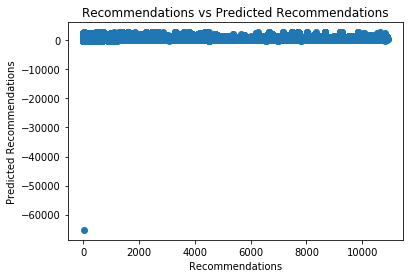

In [70]:
plt.scatter(y_train, y_pred)
plt.xlabel("Recommendations")
plt.ylabel("Predicted Recommendations")
plt.title("Recommendations vs Predicted Recommendations")
plt.show()

for col in disc_cols:
    print(f'{col} ----- ', pd.to_numeric(traintesting[col], downcast = 'integer').dtype)
    traintesting[col] = pd.to_numeric(traintesting[col], downcast = 'integer')

traintesting[bool_cols] = traintesting[bool_cols].astype(np.bool_)

cont_cols = traintesting.select_dtypes(include=np.float_).columns.to_list()
cont_int_cols = []
cont_float_cols = []

for col in cont_cols:
    print(f'{col}-----{traintesting[col].nunique()}')
    print('-'  * 30)
    print(f'{traintesting[col].unique()}')
    print('='  * 30)
    if traintesting[col].nunique() < 5 : 
        cont_int_cols.append(col)
    else:
        cont_float_cols.append(col)  

In [71]:
## Decision Tree Model
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report


In [72]:
x_train,x_test,y_train,y_test = train_test_split(traintesting.drop(['ProductRecommed'], axis=1), traintesting['ProductRecommed'],test_size = 0.30, random_state= 355)

x_train.to_csv('x_train_stand_starter.csv')
y_train.to_csv('y_train_stand_starter.csv')
x_test.to_csv('x_test_stand_starter.csv')
y_test.to_csv('y_test_stand_starter.csv')

x_train=pd.read_csv('x_train_stand_starter.csv')
y_train=pd.read_csv('y_train_stand_starter.csv')
x_test=pd.read_csv('x_test_stand_starter.csv')
y_test=pd.read_csv('y_test_stand_starter.csv')

In [73]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
reg = DecisionTreeRegressor()
reg.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [74]:
reg.score(x_test,y_test)

0.7801489981643819

## Decision Tree Regressor has been giving 78% score the best so far

## saving the training and testing dataset to try the different algorithms
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)

from sklearn.ensemble import AdaBoostRegressor
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(),n_estimators=300, random_state=300)

regr_2.fit(x_train,y_train)

regr_2.score(x_test,y_test)

from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
bagging = BaggingRegressor(KNeighborsRegressor())


x_train = np.load('x_train.npy',allow_pickle='TRUE').tolist()
y_train = np.load('y_train.npy',allow_pickle='TRUE').tolist()
x_test = np.load('test.npy',allow_pickle='TRUE').tolist()
y_test = np.load('test.npy',allow_pickle='TRUE').tolist()

# we are tuning three hyperparameters right now, we are passing the different values for both parameters
grid_param = {"criterion": ["mse"],
              "min_samples_split": [2],
              #"max_depth": [4,5,6],
              "min_samples_leaf": [1,2,4],
              #"max_leaf_nodes": [10,20,30]
              }

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(reg, grid_param, cv=5)

traintesting= ''
grid_search.fit(x_train,y_train)
best_parameters = grid_search.best_params_
print(best_parameters)

grid_search.best_score_

reg = DecisionTreeRegressor(criterion= 'mse', max_depth=2, max_leaf_nodes= 5, min_samples_leaf= 20, min_samples_split= 10)
reg.fit(x_train,y_train)

reg.score(x_test,y_test)

In [99]:
import pickle
filename = 'dtr.sav'
pickle.dump(reg, open(filename, 'wb'))
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test,y_test)
y_predict= loaded_model.predict(x_test)
print(y_predict)

[ 0.  0.  2. ...  4. 20.  4.]


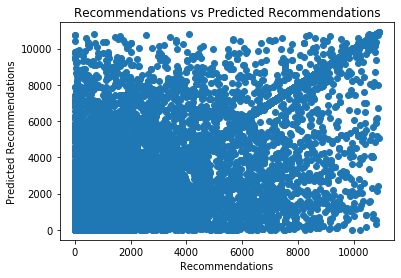

In [100]:
plt.scatter(y_test, y_predict)
plt.xlabel("Recommendations")
plt.ylabel("Predicted Recommendations")
plt.title("Recommendations vs Predicted Recommendations")
plt.show()

In [ ]:
#y_predict

In [101]:
##
x_test['ProdRecommed'] = y_test
x_test['ProdRecommedPredict'] = y_predict
x_test['ProdRecommed'].astype('str')
daf[0].astype('str')
x_test['ProdRecommed'] = x_test['ProdRecommed'].map(daf[0])
#x_test['ProdRecommed'] = x_test['ProdRecommed'].remap(daf)
x_test['ProdRecommedPredict'] = x_test['ProdRecommedPredict'].map(daf[0])

In [102]:
#x_test.replace({"ProdRecommed": daf[0]})
#x_test.replace({"ProdRecommedPredict": daf[0]})
x_test


,date,customer_code,emp_status,residence_code,sex,age,date_first_prod,new_customer,seniority_inmonths,prime_customer,...,spouse,channel,deceased,primary_address,province_code,status_ai,gincome,social_segment,ProdRecommed,ProdRecommedPredict
7919112,20151128.0,979344.0,1.0,0.0,2.0,24.0,20111115.0,0.0,48.0,1.0,...,2.0,1.0,0.0,1.0,32.0,1.0,134254.318212,3.0,Current Accounts,Current Accounts
11755480,20160328.0,1088146.0,1.0,0.0,2.0,23.0,20121024.0,0.0,41.0,1.0,...,2.0,1.0,0.0,1.0,8.0,0.0,125737.109375,3.0,Current Accounts,Current Accounts
8975134,20151228.0,1340235.0,1.0,0.0,1.0,21.0,20141023.0,0.0,14.0,1.0,...,2.0,1.0,0.0,1.0,6.0,1.0,33749.281250,3.0,"Current Accounts, Direct Debit","Current Accounts, Direct Debit"
9600531,20160128.0,517130.0,1.0,0.0,1.0,48.0,20050210.0,0.0,131.0,1.0,...,2.0,110.0,0.0,1.0,12.0,0.0,134254.318212,3.0,particular Account,particular Account
11130904,20160328.0,242070.0,1.0,0.0,1.0,49.0,20010424.0,0.0,179.0,1.0,...,2.0,3.0,0.0,1.0,28.0,1.0,89953.742188,3.0,"Current Accounts, particular Account","Current Accounts, particular Account"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707587,20160128.0,603427.0,1.0,0.0,1.0,36.0,20060318.0,0.0,118.0,1.0,...,2.0,3.0,0.0,1.0,28.0,0.0,40757.789062,3.0,,
4015903,20150728.0,176625.0,1.0,0.0,2.0,55.0,20000519.0,0.0,182.0,1.0,...,2.0,5.0,0.0,1.0,43.0,0.0,134254.318212,3.0,,
9325678,20160128.0,1379229.0,1.0,0.0,2.0,21.0,20150130.0,0.0,12.0,1.0,...,2.0,4.0,0.0,1.0,19.0,0.0,134254.318212,3.0,,
1649713,20150328.0,1342670.0,1.0,0.0,1.0,41.0,20141027.0,0.0,9.0,1.0,...,2.0,5.0,0.0,1.0,28.0,1.0,109735.226562,3.0,"Current Accounts, Más particular Account","Current Accounts, Más particular Account"


In [ ]:
print('Done. Time elapsed: {:.2f}s'.format(time.time() - total_start_time))

In [ ]:
## Save Dictionaries
np.save('ProdRecommed.npy', di) 
np.save('Residence_Code.npy', di1) 
np.save('Channel.npy', di2) 

In [70]:
x_train,x_test,y_train,y_test = train_test_split(traintesting.drop(['ProductRecommed'], axis=1), traintesting['ProductRecommed'],test_size = 0.30, random_state= 400)

In [74]:
x_train= x_train.astype('float64')

#,x_test,y_train,y_test

In [75]:
y_train= y_train.astype('float64')

In [77]:
x_test= x_test.astype('float64')
y_test = y_test.astype('float64')

In [76]:
import xgboost as xgb

dtrain = xgb.DMatrix(x_train, label=y_train)


In [78]:
dtest = xgb.DMatrix(x_test, label=y_test)

import xgboost as xgb
from sklearn.datasets import dump_svmlight_file

dump_svmlight_file(x_train, y_train, 'dtrain.svm', zero_based=True)
dump_svmlight_file(x_test, y_test, 'dtest.svm', zero_based=True)
dtrain_svm = xgb.DMatrix('dtrain.svm')
dtest_svm = xgb.DMatrix('dtest.svm')

!pip install torch
import torch
n_classes = len(torch.unique(y_train))
 

In [92]:
nc= len(y_train.unique())
nc

10379

In [97]:

params = {
    'eta':0.1,
    #'n_estimators':1000,
    'max_depth':5,
    'min_child_weight':1,
    'gamma':0,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'objective':'multi:softmax',
    'nthread':4,
    #'scale_pos_weight':1,
    'seed':27,
    'num_class':nc}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

In [98]:
bst = xgb.train(params=params, dtrain=dtrain, num_boost_round =20)
bst.dump_model('dump_xgboost.raw.txt')

XGBoostError: bad allocation

In [ ]:
y_pred = bst.predict(dtest)

In [ ]:
from sklearn.metrics import precision_score

print precision_score(y_test, y_pred, average='macro')
# >> 1.0

In [ ]:
from sklearn.externals import joblib

joblib.dump(bst, 'bst_model.pkl', compress=True)

In [ ]:
##KNN Algorithm
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(x_train,y_train)

In [ ]:
y_pred = knn.predict(x_test)

In [ ]:
print(confusion_matrix(y_test,y_pred))

In [ ]:
print(classification_report(y_test,pred))

In [ ]:
error_rate = []

# Will take some time
for i in range(1,40):
    
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    error_rate.append(np.mean(pred_i != y_test))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

# Bayesian Optimisation

In [59]:
start_time = time.time()
bayesian_tr_index, bayesian_val_index  = list(StratifiedKFold(n_splits=2, shuffle=True, random_state=1).split(traintesting, traintesting.ProductRecommed.values))[0]
print(len(bayesian_tr_index), len(bayesian_val_index))
print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

6821384 6825925
Done. Time elapsed: 965.09s


In [65]:
bayesian_val_index

array([       6,        7,        8, ..., 13647303, 13647306, 13647308])

In [68]:
# Function for LGB model creation for bayesian optimisation
start_time = time.time()
def LGB_bayesian(
    num_leaves,  # int
    min_data_in_leaf,  # int
    learning_rate,
    min_sum_hessian_in_leaf,    # int  
    feature_fraction,
    lambda_l1,
    lambda_l2,
    min_gain_to_split,
    max_depth):
    
    # LightGBM expects next three parameters need to be integer. So we make them integer
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int

    param = {
        'num_leaves': num_leaves,
        'max_bin': 63,
        'min_data_in_leaf': min_data_in_leaf,
        'learning_rate': learning_rate,
        'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
        'bagging_fraction': 1.0,
        'bagging_freq': 5,
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'min_gain_to_split': min_gain_to_split,
        'max_depth': max_depth,
        'save_binary': True, 
        'seed': 13,
        'feature_fraction_seed': 13,
        'bagging_seed': 13,
        'drop_seed': 13,
        'data_random_seed': 13,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,   

    }    
    
    
    xg_train = lgb.Dataset(x_train.iloc[bayesian_tr_index][y_train].values,
                           label=x_train.iloc[bayesian_tr_index][y_train].values,
                           feature_name=y_train,
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(x_train.iloc[bayesian_val_index][y_train].values,
                           label=x_train.iloc[bayesian_val_index][y_train].values,
                           feature_name=y_train,
                           free_raw_data = False
                           ) 

    num_round = 5000
    clf = lgb.x_train(param, xg_train, num_round, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50)
    
    predictions = clf.predict(x_train.iloc[bayesian_val_index][y_train].values, num_iteration=clf.best_iteration)   
    
    score = roc_auc_score(x_train.iloc[bayesian_val_index][y_train].values, predictions)
    
    return score

# Region Space for Bayesian Optimisation
region_space_LGB = {
    'num_leaves': (5, 20), 
    'min_data_in_leaf': (5, 20),  
    'learning_rate': (0.01, 0.3),
    'min_sum_hessian_in_leaf': (0.00001, 0.01),    
    'feature_fraction': (0.05, 0.5),
    'lambda_l1': (0, 5.0), 
    'lambda_l2': (0, 5.0), 
    'min_gain_to_split': (0, 1.0),
    'max_depth':(3,15),
}

LGB_BO = BayesianOptimization(LGB_bayesian, region_space_LGB, random_state=13)
print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

Done. Time elapsed: 0.00s


In [69]:
init_points = 5
n_iter = 5
LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>

NameError: name 'x_train' is not defined

In [ ]:
start_time = time.time()
init_points = 5
n_iter = 5

LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)
print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

In [ ]:
LGB_BO.max['ProductRecommed']

In [ ]:
LGB_BO.max['params']

In [ ]:
param_lgb = {
        'num_leaves': int(LGB_BO.max['params']['num_leaves']),
        'max_bin': 63,
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']),
        'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_sum_hessian_in_leaf': LGB_BO.max['params']['min_sum_hessian_in_leaf'],
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': LGB_BO.max['params']['feature_fraction'],
        'lambda_l1': LGB_BO.max['params']['lambda_l1'],
        'lambda_l2': LGB_BO.max['params']['lambda_l2'],
        'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'],
        'max_depth': int(LGB_BO.max['params']['max_depth']),
        'save_binary': True,
        'seed': 13,
        'feature_fraction_seed': 13,
        'bagging_seed': 13,
        'drop_seed': 13,
        'data_random_seed': 13,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
    }

# Model Interpreting
### ELI5

import eli5

model = lgb.LGBMClassifier(**param_lgb, n_estimators = 20000, n_jobs = -1)
X_train, X_valid, y_train, y_valid = train_test_split(train[features], train[target], test_size=0.2, stratify=train[target])
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

eli5.show_weights(model, targets=[0, 1], feature_names=list(X_train.columns), top=40, feature_filter=lambda x: x != '<BIAS>')

#### Taking top 100 features and checking if the scores improves.

top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:100]
X1 = train[top_features]
X_train, X_valid, y_train, y_valid = train_test_split(X1, train[target], test_size=0.2, stratify=train[target])
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=200)

* Without removal score : 0.89538
* With removal score : 0.883403

**So ELI5 isn't helping in reducing the features.**

# 5Fold Prediction & Submission

%%time
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

y_pred_lgb = np.zeros(len(test))
num_round = 20000
for fold_n, (train_index, valid_index) in enumerate(folds.split(train[features], train[target])):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train[features].iloc[train_index], train[features].iloc[valid_index]
    y_train, y_valid = train[target].iloc[train_index], train[target].iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    lgb_model = lgb.train(
        param_lgb,
        train_data,num_round,
        valid_sets = [train_data, valid_data],
        verbose_eval=1000,
        early_stopping_rounds = 1000)
            
    y_pred_lgb += lgb_model.predict(test[features], num_iteration=lgb_model.best_iteration)/5

# Submitting the 5Fold LGB Predictions
submission_lgb = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_lgb
    })
submission_lgb.to_csv('sub_lgb.csv', index=False)

# This submission score 0.90038 on public leaderboard. (Almost top 9% in Public LB)

# Conclusion

TODO - 
1. H20 AutoML
1. Using XGBoost, Catboost
1. Ensembling, Stacking, Blending
1. Feature Removal